In [ ]:
#@title Import Statements
import os
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import warnings 
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Lambda
from __future__ import print_function, division
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import copy
import shutil



# Basic data loading/extraction and analysis

In [ ]:
###Helper Methods

# returns a dict mapping values to index and also a dict mapping index to values 
def getStringIndexMappings(value_list):
    return {value_list[i]: i for i in range(len(value_list))}, {i: value_list[i] for i in range(len(value_list))}

#returns classification error
def getCError(data, predictions):
    correct = 0
    for i in range(len(data[0])):
        correct = correct + int(predictions[i] == data[1][i])
    return (1 - (correct / len(data[0]))) * 100


In [ ]:
# get the dataset 
!gdown --id 1EcTXr3CU9kV1PTq6zv-8OG_dg4CI2tpa
directory = "minecraft_images"
# create a directory on this vm
new_directory_path = os.path.join(os.getcwd(), directory)
os.mkdir(new_directory_path)
#extract the dataset into this new directory
with zipfile.ZipFile('minecraft_image_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall(new_directory_path)

Downloading...
From: https://drive.google.com/uc?id=1EcTXr3CU9kV1PTq6zv-8OG_dg4CI2tpa
To: /content/minecraft_image_dataset.zip
100% 8.21G/8.21G [01:16<00:00, 107MB/s]


In [ ]:
print(os.listdir(new_directory_path))
new_directory_path = os.path.join(new_directory_path,os.listdir(new_directory_path)[0])
new_directory_path 

['machine learning 2']


'/content/minecraft_images/machine learning 2'

In [ ]:
# create the main dataframe with the following columns
# procedural_generation_label one of “Great”, “Ok” and “Bad”, “Degenerate” - marks quality of procedural generation in image
pg_labels = ["Great", "Ok", "Bad", "Degenerate"]
pg_label_to_index, pg_index_to_label = getStringIndexMappings(pg_labels)
# procedural_generation_type one of "Structure”, “OpenLandscape” and “UndergroundLandscape” - a descriptor for type of procedural generation in image
procedural_generation_types = ["Structure", "OpenLandscape", "UndergroundLandscape"]
pg_type_to_index, pg_index_to_type = getStringIndexMappings(pg_labels)
# biome in game minecraft label for the biome the procedural generation was in 
# time_of_day one of "day" or "night" describes wether the image of the procedural generation was taken during the day or the night
# x_cord the x coordinate of the procedural generation
# z_cord the z coordinate of the procedural generation
# version the minecraft version the procedural generation was found in
# seed the minecraft world seed the procedural generation was found in
# image_index or image index is the image number looking at a specific procedural generation(there should be around 100 images looking at any procedural generation from diffrent angles)
# pg_index is the index for what specific procedural generation is being looked at
# image_data is the image itself(is loaded later)
# image name is the name of the image
image_df = pd.DataFrame({'procedural_generation_label' : [],
                         'procedural_generation_type' : [],
                         'biome' : [], 'time_of_day' : [],
                         'x_cord' : [], 'z_cord' : [], 'version' : [],
                         'seed' : [],'image_index' : [],'image_data' : [], 
                         'image_name' : []})
# for every image in the directory just created add a corrisopoding entry in the dataframe
for image_file_name in os.listdir(new_directory_path):
    image_file_info  = image_file_name.split("_")
    # get rid of the png at the end of the last item
    image_file_info[-1] = image_file_info[-1][:-4]
    # add a image placeholder for now
    image_file_info.append(0)
    # add a image name for now
    image_file_info.append(image_file_name)
    image_df.loc[len(image_df.index)] = image_file_info 
# add pg_index thus noting what images are looking at the same thing 
# this is needed to prevent the images lookoing at the same object being in two diffrent sets
unique_pgs = image_df.set_index(['x_cord', 'z_cord','version','seed']).index.values
pg_to_index = {}
pg_index_count = 0;
for unique_pg in unique_pgs:
    if unique_pg not in pg_to_index:
        pg_to_index[unique_pg] = pg_index_count
        pg_index_count += 1
image_df["pg_index"]=  image_df.set_index(['x_cord', 'z_cord','version','seed']).index.map(pg_to_index)
# randomize the order 
image_df = image_df.sample(frac=1, random_state=1)
# used for training test split
pg_index_unique_values = image_df["pg_index"].unique()

In [ ]:
#returns a image file name from a row of image_df
def getImageFileName(image_df_row):
    return image_df_row['image_name']


procedural_generation_label                                                   Ok
procedural_generation_type                                             Structure
biome                                                                     plains
time_of_day                                                                  day
x_cord                                                                     -3599
z_cord                                                                      3415
version                                                                   1.16.5
seed                                                                        1111
image_index                                                                   61
image_data                                                                     0
image_name                     Ok_Structure_plains_day_-3599_3415_1.16.5_1111...
pg_index                                                                      17
Name: 7978, dtype: object


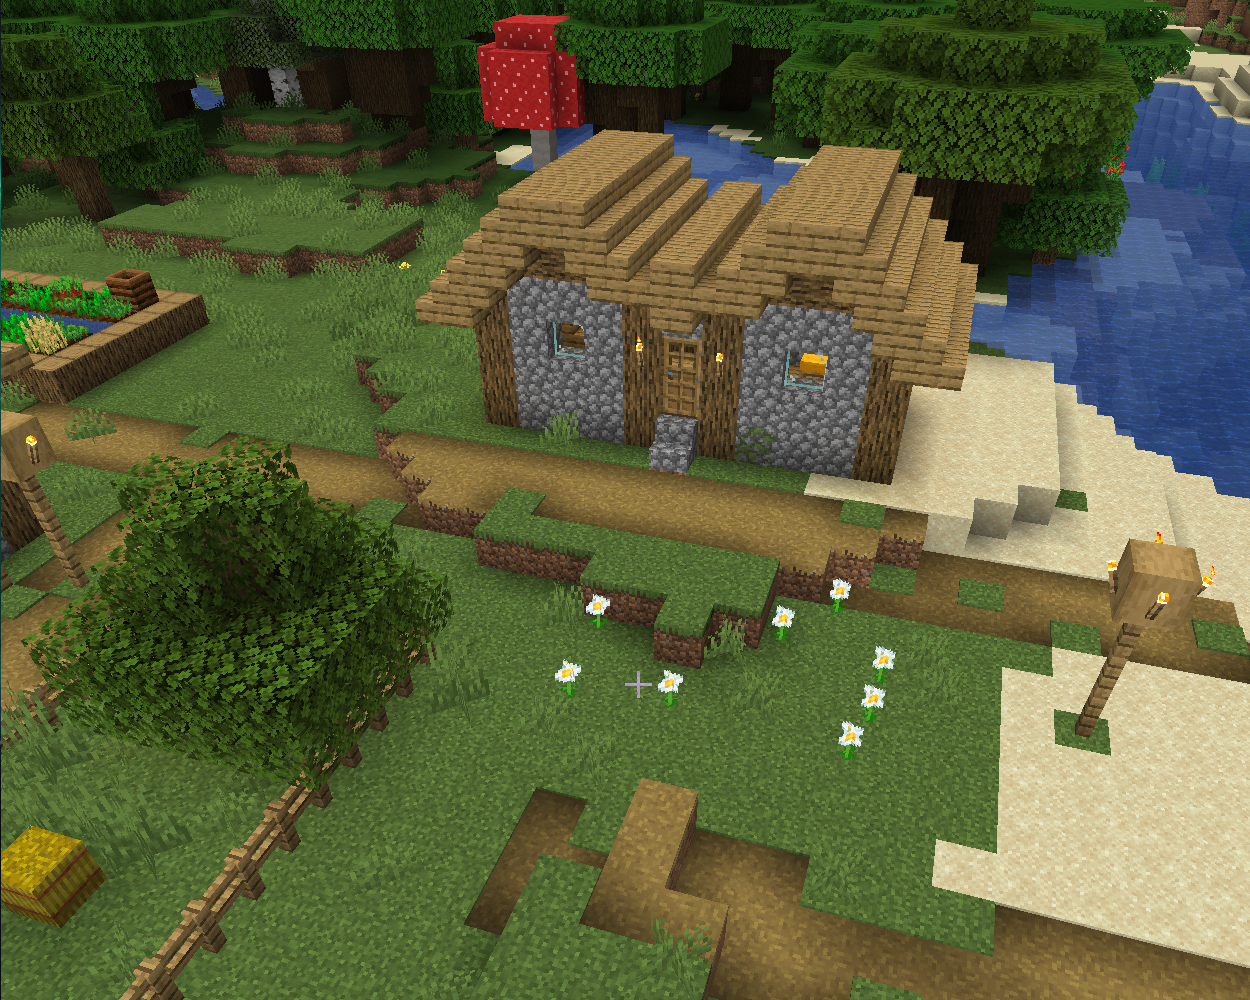

In [ ]:
# example image
print(image_df.iloc[0])
Image.open( os.path.join(new_directory_path, getImageFileName(image_df.iloc[0]))) 

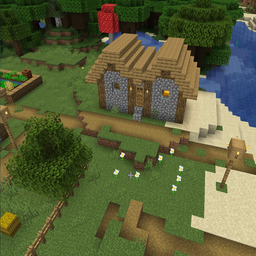

In [ ]:
img = Image.open( os.path.join(new_directory_path, getImageFileName(image_df.iloc[0]))) 
img = img.resize((256,256),Image.ANTIALIAS)
img

Different labels of quality of the procedural generations


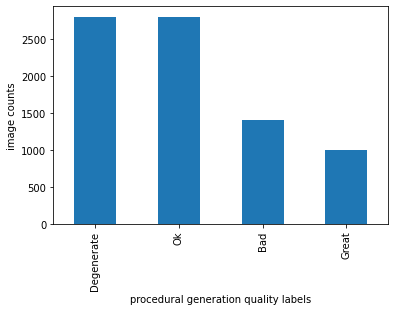

In [ ]:
image_df["procedural_generation_label"].value_counts().plot(kind = 'bar', xlabel = "procedural generation quality labels",ylabel="image counts")
print("Different labels of quality of the procedural generations")

Different descriptors for type of procedural generation in images


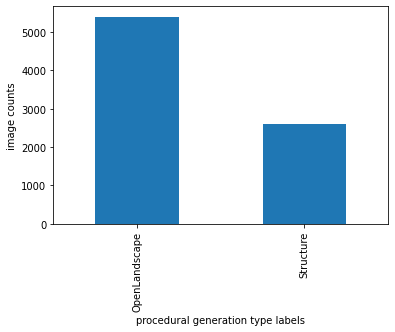

In [ ]:
image_df["procedural_generation_type"].value_counts().plot(kind = 'bar', xlabel = "procedural generation type labels",ylabel="image counts")
print("Different descriptors for type of procedural generation in images")

Different in game minecraft labels for the biome the procedural generations were in


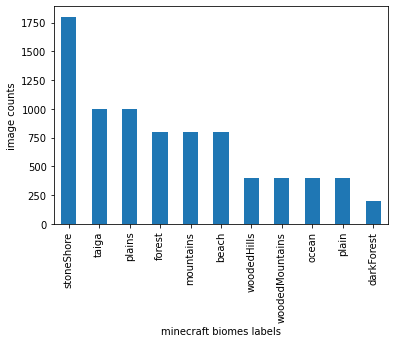

In [ ]:
image_df["biome"].value_counts().plot(kind = 'bar', xlabel = "minecraft biomes labels",ylabel="image counts")
print("Different in game minecraft labels for the biome the procedural generations were in")

Different minecraft world seeds the procedural generations were found in


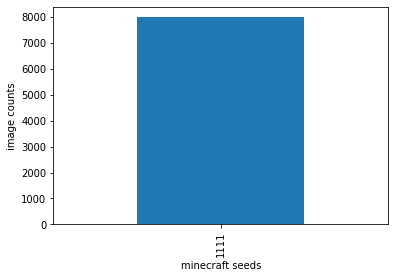

In [ ]:
image_df["seed"].value_counts().plot(kind = 'bar', xlabel = "minecraft seeds",ylabel="image counts")
print("Different minecraft world seeds the procedural generations were found in")

In [ ]:
# get 70% train, 20% test and 10% validation set split randomly
# allows inputing of a column whose values that are the same will always stay in the same set
# this is used to prevent information bleed between the sets 
# for example if two images are looking at the same content just from diffrent angles you want them in the same set
def getTrainTestValOld(df, keep_together_column=None) :  
    # first randomize
    random_df = df.sample(frac=1, random_state=1)
    if keep_together_column == None:
        train_set = random_df[:int(len(random_df)*.7)].reset_index().drop(["index"], axis=1)
        test_set = random_df[int(len(random_df)*.7):int(len(random_df)*.9)].reset_index().drop(["index"], axis=1)
        validation_set = random_df[int(len(random_df)*.9):].reset_index().drop(["index"], axis=1)
    else:
        total_num_items = len(random_df)
        current_num_items = 0
        kt_values = random_df[keep_together_column].unique()

        train_set = []
        test_set = []
        validation_set = []

        for kt_index in range(len(kt_values)):
            kt_value_df = random_df[random_df[keep_together_column] == kt_values[kt_index]]
            if total_num_items * .7 > current_num_items:
                train_set.append(kt_value_df)
            elif total_num_items * .9 > current_num_items:
                test_set.append(kt_value_df)
            else:
                validation_set.append(kt_value_df)
            current_num_items += len(kt_value_df)
    
        train_set = pd.concat(train_set).reset_index().drop(["index"], axis=1)
        test_set = pd.concat(test_set).reset_index().drop(["index"], axis=1)
        validation_set = pd.concat(validation_set).reset_index().drop(["index"], axis=1)
    return train_set, test_set, validation_set

# this is the same as the above but sets a consistant train test split if keep together colum is pg_index so the test train splits are the same
def getTrainTestVal(df, keep_together_column=None) :  
    # first randomize
    random_df = df.sample(frac=1, random_state=1)
    if keep_together_column == None:
        train_set = random_df[:int(len(random_df)*.7)].reset_index().drop(["index"], axis=1)
        test_set = random_df[int(len(random_df)*.7):int(len(random_df)*.9)].reset_index().drop(["index"], axis=1)
        validation_set = random_df[int(len(random_df)*.9):].reset_index().drop(["index"], axis=1)
    else:
        total_num_items = len(random_df)
        current_num_items = 0
        if keep_together_column =="pg_index":
            kt_values = pg_index_unique_values
        else:
            kt_values = random_df[keep_together_column].unique()

        train_set = []
        test_set = []
        validation_set = []

        for kt_index in range(len(kt_values)):
            kt_value_df = random_df[random_df[keep_together_column] == kt_values[kt_index]]
            if total_num_items * .7 > current_num_items:
                train_set.append(kt_value_df)
            elif total_num_items * .9 > current_num_items:
                test_set.append(kt_value_df)
            else:
                validation_set.append(kt_value_df)
            current_num_items += len(kt_value_df)
    
        train_set = pd.concat(train_set).reset_index().drop(["index"], axis=1)
        test_set = pd.concat(test_set).reset_index().drop(["index"], axis=1)
        validation_set = pd.concat(validation_set).reset_index().drop(["index"], axis=1)
    return train_set, test_set, validation_set




In [ ]:
# change the procedural generation label into a numerical values
image_df["procedural_generation_label"] = image_df["procedural_generation_label"].map(pg_label_to_index)

# Classic computer vision approches 

In [ ]:
#detremines the max number of iterations will be done in sklearn model training
# warining increasing past 2000 will result in 24+ run times for this section 
sklearn_max_iter = 1000

# gets a dataset that can be inputted into sklearn models 
# assumes input featues are numerical or numerical arrays and output features are numerical
# takes in a dataframe and the list of columns that contain the input features and the string that is the output_feature_column
# returns data set with input features as a flat vector and with the output as a scalar 
# a little inefficent but readable
def getFlatDataSets(df,input_features_columns,output_feature_column):
    x = []
    y = []
    for index, row in df.iterrows():
        xi = []
        for input_features_column in input_features_columns:
            xi = np.hstack([xi,np.array([row[input_features_column]]).flatten()])
        x.append(xi)
        y.append([row[output_feature_column]])
    return np.array(x), np.array(y)

# takes in a training dataset a testing dataset and a validation dataset
# will do Logistic Regression Training Testing and will do hyper parameter tuning over regularization hyperparameter on the test set
# and based on the model with the maximum performance on the test set will return the classsification error from all three data sets 
from sklearn.linear_model import LogisticRegression
def LogisticRegressionTrainTest(train_data,test_data,val_data):
    #hyperparameter for tuning
    regularization_strengths = [.1,1,10,100]

    best_error = 100000
    best_model = ""
    #hyperparameter tuning
    for regularization_strength in regularization_strengths:
        model = LogisticRegression(random_state=0,C=regularization_strength,solver='lbfgs', max_iter = sklearn_max_iter).fit(train_data[0], train_data[1].ravel())
        error = getCError(test_data, model.predict(test_data[0]))
        if(error < best_error) :
            best_error = error
            best_model  = model
    
    print("classification error for Logistic Regression training set = ",getCError(train_data, model.predict(train_data[0])), "%")
    print("classification error for Logistic Regression test set = ",getCError(test_data, model.predict(test_data[0])), "%")
    print("classification error for Logistic Regression validation set = ",getCError(val_data, model.predict(val_data[0])), "%\n")

# takes in a training dataset a testing dataset and a validation dataset
# will do Linear Support Vector Machine Training Testing and will do hyper parameter tuning over regularization hyperparameter on the test set
# and based on the model with the maximum performance on the test set will return the classsification error from all three data sets 
from sklearn.svm import LinearSVC
def LinearSVMTrainTest(train_data,test_data,val_data):
    #hyperparameter for tuning
    regularization_strengths = [.1,1,10,100]
    best_error = 1000
    #hyperparameter tuning
    for regularization_strength in regularization_strengths:
        model = LinearSVC(random_state=0, C=regularization_strength, max_iter = sklearn_max_iter).fit(train_data[0], train_data[1].ravel())
        error = getCError(test_data, model.predict(test_data[0]))
        if(error < best_error) :
            best_error = error
            best_model  = model
    
    print("classification error for Linear SVM training set = ",getCError(train_data, model.predict(train_data[0])), "%")
    print("classification error for Linear SVM test set = ",getCError(test_data, model.predict(test_data[0])), "%")
    print("classification error for Linear SVM validation set = ",getCError(val_data, model.predict(val_data[0])), "%\n")

# takes in a training dataset a testing dataset and a validation dataset
# will do General Support Vector Machine Testing and will do hyper parameter tuning over kernel hyperparameter on the test set
# and based on the model with the maximum performance on the test set will return the classsification error from all three data sets 
from sklearn.svm import SVC
def GeneralSVMTrainTest(train_data,test_data,val_data):
    #hyperparameter for tuning
    kernels = ["poly", "rbf", "sigmoid"]
    best_error = 1000
    best_model = ""
    #hyperparameter tuning
    for kernel in kernels:
        model = SVC(C=10.0, kernel=kernel, random_state=0, shrinking=True, max_iter = sklearn_max_iter).fit(train_data[0], train_data[1].ravel())
        error = getCError(test_data, model.predict(test_data[0]))
        if(error < best_error) :
            best_error = error
            best_model  = model
    
    print("classification error for General SVM training set = ",getCError(train_data, best_model.predict(train_data[0])), "%")
    print("classification error for General SVM test set = ",getCError(test_data, best_model.predict(test_data[0])), "%")
    print("classification error for General SVM validation_set = ",getCError(val_data, best_model.predict(val_data[0])), "%\n")

#trains and tests Logistic regression and Support Vector Machines and prints the results
# allows inputing of a column whose values that are the same will always stay in the same set
# this is used to prevent information bleed between the sets 
# for example if two images are looking at the same content just from diffrent angles you want them in the same set
def trainTestLRSVM(df,input_features_columns,output_feature_column, keep_together_column=None):
    train_set, test_set, validation_set = getTrainTestVal(df,keep_together_column)
    # get the flat datasets
    train_data = getFlatDataSets(train_set,input_features_columns,output_feature_column)
    test_data = getFlatDataSets(test_set,input_features_columns,output_feature_column)
    val_data = getFlatDataSets(validation_set,input_features_columns,output_feature_column)
    # train test and print results
    LogisticRegressionTrainTest(train_data,test_data,val_data)
    LinearSVMTrainTest(train_data,test_data,val_data)
    GeneralSVMTrainTest(train_data,test_data,val_data)

#returns a dataframe with image vector data added with specified size 
def getImageDataDF(df,imgsize):
    #used to add an compressed image to dataframe as a vector
    def getImageAsVector(row):
        img = Image.open( os.path.join(new_directory_path, getImageFileName(row))) 
        row["image_data"] = np.array(img.resize((imgsize,imgsize),Image.ANTIALIAS).getdata())
        return row
    return df.apply(getImageAsVector, axis=1)

In [ ]:
#use this to get rid of warinings on the fact that it wants more iterations for convergence on smaller images
warnings.filterwarnings("ignore")

In [ ]:
full_image_df = ""

In [ ]:
# try training with diffrent image sizes print reults 
for imgsize in [32, 64, 128, 256]:
    print("**********IMAGE SIZE = " + str(imgsize) + "***************"*6 + "\n" * 3)
    full_image_df = getImageDataDF(image_df,imgsize)
    print("**********4 Procedural Generation Labels" + "***************"*4 + "\n" * 2)
    print("**********Standard Train Test Validation Split" + "***************"*3 + "\n" * 2)
    print("**********All Data" + "***************"*2 + "\n" * 1)
    trainTestLRSVM(full_image_df,["image_data"],"procedural_generation_label")
    
    print("**********No Information bleed Train Test Validation Split" + "***************"*3 + "\n" * 2)
    trainTestLRSVM(full_image_df,["image_data"],"procedural_generation_label", "pg_index")
    # map the procedural_generation_label to two labels good and bad
    full_image_df["procedural_generation_label"] = image_df["procedural_generation_label"].map({0:0, 1:0, 2:1, 3:1})
    print("**********2 Procedural Generation Labels" + "***************"*4 + "\n" * 2)
    print("**********Good and Bad Procedural Generation Labels" + "***************"*2 + "\n" * 2)
    print("**********Standard Train Test Validation Split" + "***************"*3 + "\n" * 2)
    trainTestLRSVM(full_image_df,["image_data"],"procedural_generation_label")
    print("**********No Information bleed Train Test Validation Split" + "***************"*3 + "\n" * 2)
    trainTestLRSVM(full_image_df,["image_data"],"procedural_generation_label", "pg_index")
    print("**********Not degenerate Procedural Generation Labels" + "***************"*2 + "\n" * 2)
    full_image_df["procedural_generation_label"] = image_df["procedural_generation_label"].map({0:0, 1:0, 2:0, 3:1})
    print("**********Standard Train Test Validation Split" + "***************"*3 + "\n" * 2)
    trainTestLRSVM(full_image_df,["image_data"],"procedural_generation_label")
    print("**********No Information bleed Train Test Validation Split" + "***************"*3 + "\n" * 2)
    trainTestLRSVM(full_image_df,["image_data"],"procedural_generation_label", "pg_index")

**********IMAGE SIZE = 32******************************************************************************************



**********4 Procedural Generation Labels************************************************************


**********Standard Train Test Validation Split*********************************************


**********All Data******************************

classification error for Logistic Regression training set =  1.7330712881901023 %
classification error for Logistic Regression test set =  45.465916197623514 %
classification error for Logistic Regression validation set =  47.25 %

classification error for Linear SVM training set =  17.25924602465606 %
classification error for Linear SVM test set =  47.71732332707942 %
classification error for Linear SVM validation set =  49.5 %

classification error for General SVM training set =  11.506164016437381 %
classification error for General SVM test set =  19.387116948092554 %
classification error for General SVM validation_set =  1

In [ ]:
#auxiliary analysis of predicting other labels besides procedural generation quality(procedural generation type and time of day)

for imgsize in [32, 64, 128, 256]:
    print(("**********IMAGE SIZE = " + str(imgsize) + "*************************************** \n")*6)
    full_image_df = getImageDataDF(image_df,imgsize)
    full_image_df["time_of_day"] = full_image_df["time_of_day"].map({"day":0,"night":1})
    full_image_df["procedural_generation_type"] = full_image_df["procedural_generation_type"].map({"Structure":0,"OpenLandscape":1,"UndergroundLandscape":2})
    print(("**********time of day*************************************** \n")*4)
    print(("**********Standard Train Test Validation Split*************************************** \n")*2)
    trainTestLRSVM(full_image_df,["image_data"],"time_of_day")
    print(("**********No Information bleed Train Test Validation Split*************************************** \n")*2)
    trainTestLRSVM(full_image_df,["image_data"],"time_of_day", "pg_index")
    print(("**********procedural generation type*************************************** \n")*4)
    print(("**********Standard Train Test Validation Split*************************************** \n")*2)
    trainTestLRSVM(full_image_df,["image_data"],"procedural_generation_type")
    print(("**********No Information bleed Train Test Validation Split*************************************** \n")*2)
    trainTestLRSVM(full_image_df,["image_data"],"procedural_generation_type", "pg_index")

# Custom Neural Net Computer Vision Approachs  

In [ ]:
# if you want to run this next you are going to want a gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
print(device)

In [ ]:
class MinecraftImageDataset(Dataset):
    def __init__(self, img_labels,transform,img_size, target_transform=None):
        self.img_labels = img_labels
        self.img_dir = new_directory_path
        self.transform = transform
        self.target_transform = target_transform
        self.img_size = img_size

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        #print(self.img_labels[idx])
        img_path = os.path.join(self.img_dir, self.img_labels[idx]["image_file_name"])
        #image = read_image(img_path).resize((5,5),Image.ANTIALIAS)
        image = Image.open(img_path).resize((self.img_size,self.img_size),Image.ANTIALIAS)
        label = int (self.img_labels[idx]["label"])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {"image": image, "label": label}
        return sample

In [ ]:
#takes in training test valadation sets and outputs training test val dataloaders
# also takes in a column name where it will use as labels(must be numeric)
def getTrainingTestValDataLoaders(train_set, test_set, validation_set, label_column, transform, img_size=32):
    #returns a dataframe with just columns "image_file_name" which is the image file name 
    def convertToFileNameNLabelDf(row):
        new_row ={}
        new_row["label"] = row[label_column]
        new_row["image_file_name"] = getImageFileName(row)
        return new_row
    
    #return train_set.apply(convertToFileNameNLabelDf, axis=1)
    train_dataloader = torch.utils.data.DataLoader(MinecraftImageDataset(train_set.apply(convertToFileNameNLabelDf, axis=1), transform, img_size))
    test_dataloader =torch.utils.data.DataLoader(MinecraftImageDataset(test_set.apply(convertToFileNameNLabelDf, axis=1), transform, img_size))
    val_dataloader =torch.utils.data.DataLoader(MinecraftImageDataset(validation_set.apply(convertToFileNameNLabelDf, axis=1), transform, img_size))
    return train_dataloader, test_dataloader, val_dataloader


In [ ]:
# small neural net with two convolutional layers and 3 deeply connected layers
# with varible input sizes
class SmallNet(nn.Module):
    def __init__(self, img_size, output_class_num):
        super().__init__()
        self.fc1_con = int ((((img_size/2) - 2)/2 - 2)**2)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * self.fc1_con, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_class_num)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))

        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 16 * self.fc1_con)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# small neural net with four convolutional layers and 3 deeply connected layers
# with a constant input size of 128 by 128
class MediumNet(nn.Module):
    def __init__(self, output_class_num):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(1024, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_class_num)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# trains the given neural net allows for collumns to keep together to prevent information bleed
def train_net(image_df, label_column, transform, net, img_size, epoch_num, keep_together_column=None):
    train, test, val = getTrainTestVal(image_df, keep_together_column)
    trainloader, testloader, validation_loader =getTrainingTestValDataLoaders( train, test, val, label_column, transform, img_size)
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(epoch_num):  # loop over the dataset multiple times

        print("EPOCH - " + str(epoch))
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs= data['image'].cuda()
            labels= data['label'].cuda()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        correct = 0
        total = 0
        with torch.no_grad():
            for data in trainloader:
                labels = data["label"].cuda()
                outputs = net(data['image'].cuda())
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the train images: %d %%' % (100 * correct / total))
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                labels = data["label"].cuda()
                outputs = net(data['image'].cuda())
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

In [ ]:
 img_size = 64
 transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
 

In [ ]:
# lets try diffrent things with a small custom net
epoch_num = 5
# create binary labels
binary_image_df = image_df.sample(frac=1, random_state=1)
binary_image_df["procedural_generation_label"] = image_df["procedural_generation_label"].map({0:0, 1:0, 2:1, 3:1})
for img_size in [32,64,128]:
    print("**********IMAGE SIZE = " + str(img_size) + "***************"*6 + "\n" * 3)
    
    print("**********Standard Train Test Validation Split" + "***************"*3 + "\n" * 2)
    print("**********4 Procedural Generation Labels" + "***************"*4 + "\n" * 2)
    net = SmallNet(img_size, 4)
    train_net(image_df, "procedural_generation_label", transform, net, img_size, epoch_num)

    print("**********No Information bleed Train Test Validation Split" + "***************"*3 + "\n" * 2)
    net = SmallNet(img_size, 4)
    train_net(image_df, "procedural_generation_label", transform, net, img_size, epoch_num, "pg_index")
    print("**********2 Procedural Generation Labels" + "***************"*4 + "\n" * 2)
    print("**********Good Bad Procedural Generation Labels" + "***************"*2 + "\n" * 2)
    net = SmallNet(img_size, 4)

    print("**********Standard Train Test Validation Split" + "***************"*3 + "\n" * 2)
    net = SmallNet(img_size, 2)
    train_net(binary_image_df, "procedural_generation_label", transform, net, img_size, epoch_num)
    print("**********No Information bleed Train Test Validation Split" + "***************"*3 + "\n" * 2)
    net = SmallNet(img_size, 2)
    train_net(binary_image_df, "procedural_generation_label", transform, net, img_size,epoch_num,  "pg_index")

    binary_image_df["procedural_generation_label"] = image_df["procedural_generation_label"].map({0:0, 1:0, 2:0, 3:1})
    print("**********Degenerate or not label" + "***************"*2 + "\n" * 2)
    print("**********Standard Train Test Validation Split" + "***************"*3 + "\n" * 2)
    net = SmallNet(img_size, 2)
    train_net(binary_image_df, "procedural_generation_label", transform, net, img_size, epoch_num)
    print("**********No Information bleed Train Test Validation Split" + "***************"*3 + "\n" * 2)
    net = SmallNet(img_size, 2)
    train_net(binary_image_df, "procedural_generation_label", transform, net, img_size,epoch_num, "pg_index")


In [ ]:
# lets try diffrent things with a medeium custom net
binary_image_df["procedural_generation_label"] = image_df["procedural_generation_label"].map({0:0, 1:0, 2:1, 3:1})
img_size = 128
print("**********Standard Train Test Validation Split" + "***************"*3 + "\n" * 2)
print("**********4 Procedural Generation Labels" + "***************"*4 + "\n" * 2)
net = MediumNet(4)
train_net(image_df, "procedural_generation_label", transform, net, img_size, epoch_num)
print("**********No Information bleed Train Test Validation Split" + "***************"*3 + "\n" * 2)
net = MediumNet(4)
train_net(image_df, "procedural_generation_label", transform, net, img_size, "pg_index")
print("**********2 Procedural Generation Labels" + "***************"*4 + "\n" * 2)
print("**********Good Bad Procedural Generation Labels" + "***************"*2 + "\n" * 2)
print("**********Standard Train Test Validation Split" + "***************"*3 + "\n" * 2)
net = MediumNet(2)
train_net(image_df, "binary_procedural_generation_label", transform, net, img_size, epoch_num)
print("**********No Information bleed Train Test Validation Split" + "***************"*3 + "\n" * 2)
net = MediumNet(2)
train_net(image_df, "binary_procedural_generation_label", transform, net, img_size, "pg_index")
binary_image_df["procedural_generation_label"] = image_df["procedural_generation_label"].map({0:0, 1:0, 2:0, 3:1})
print("**********Degenerate or not label" + "***************"*2 + "\n" * 2)
print("**********Standard Train Test Validation Split" + "***************"*3 + "\n" * 2)
net = MediumNet(2)
train_net(image_df, "binary_procedural_generation_label", transform, net, img_size, epoch_num)
print("**********No Information bleed Train Test Validation Split" + "***************"*3 + "\n" * 2)
net = MediumNet(2)
train_net(image_df, "binary_procedural_generation_label", transform, net, img_size, "pg_index")

# Transfer Learning Computer Vision Approches

In [ ]:
# create a data split file system with diffrent with diffrent names
transpher_learning_directory = "minecraft_transpher_learning_data"
# create a directory on this vm
transpher_learning_directory_path = os.path.join(os.getcwd(), transpher_learning_directory)
os.mkdir(transpher_learning_directory_path)
# create train and val directories
os.mkdir(os.path.join(transpher_learning_directory_path,"train"))
os.mkdir(os.path.join(transpher_learning_directory_path,"val"))
# create a directory for all diffrent labels within these
for label in pg_labels:
    os.mkdir(os.path.join(transpher_learning_directory_path,"train",label))
    os.mkdir(os.path.join(transpher_learning_directory_path,"val",label))
# change the procedural generation numerical into a labels values
image_df["procedural_generation_label"] = image_df["procedural_generation_label"].map(pg_index_to_label)

In [ ]:
# copy all images into these new label folder just do no bleed as we have seen at this point that is all that matters
train, test, val = getTrainTestVal(image_df, "pg_index")
# no test set here
val = pd.concat([test, val]).reset_index().drop(["index"], axis=1)
def copyImg(row):
    img_file_name = getImageFileName(row)
    dest = os.path.join(transpher_learning_directory, current_folder,row["procedural_generation_label"])
    shutil.copy(os.path.join(new_directory_path, img_file_name), dest)

current_folder = "train"
train.apply(copyImg, axis=1)

current_folder = "val"
val.apply(copyImg, axis=1)

print(os.listdir(transpher_learning_directory))

['val', 'train']


In [ ]:
os.listdir(transpher_learning_directory_path + "/val")

['Bad', 'Ok', 'Great', 'Degenerate']

In [ ]:
### SOME OF THIS CODE WAS TAKEN FROM https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = transpher_learning_directory
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

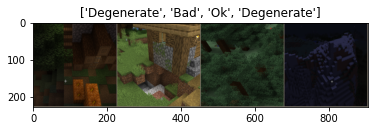

In [ ]:
### SOME OF THIS CODE WAS TAKEN FROM https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
### SOME OF THIS CODE WAS TAKEN FROM https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
### THIS CODE WAS TAKEN FROM https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
def evalModel(model_ft,num_epochs, output_classes):
    num_ftrs = model_ft.fc.in_features
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model_ft.fc = nn.Linear(num_ftrs, output_classes)

    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=num_epochs)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
evalModel(models.resnet18(pretrained=True), 24, 4)

Epoch 0/23
----------
train Loss: 0.8208 Acc: 0.6946
val Loss: 2.1680 Acc: 0.4823

Epoch 1/23
----------
train Loss: 0.5470 Acc: 0.8047
val Loss: 2.9951 Acc: 0.3836

Epoch 2/23
----------
train Loss: 0.4254 Acc: 0.8596
val Loss: 3.1907 Acc: 0.4418

Epoch 3/23
----------
train Loss: 0.3545 Acc: 0.8847
val Loss: 3.4615 Acc: 0.3700

Epoch 4/23
----------
train Loss: 0.3264 Acc: 0.8906
val Loss: 4.3146 Acc: 0.4759

Epoch 5/23
----------
train Loss: 0.2721 Acc: 0.9087
val Loss: 4.5364 Acc: 0.4114

Epoch 6/23
----------
train Loss: 0.2497 Acc: 0.9132
val Loss: 3.8170 Acc: 0.4173

Epoch 7/23
----------
train Loss: 0.1795 Acc: 0.9412
val Loss: 3.8982 Acc: 0.3691

Epoch 8/23
----------
train Loss: 0.1597 Acc: 0.9476
val Loss: 3.4311 Acc: 0.4150

Epoch 9/23
----------
train Loss: 0.1438 Acc: 0.9577
val Loss: 3.6445 Acc: 0.4259

Epoch 10/23
----------
train Loss: 0.1346 Acc: 0.9538
val Loss: 3.3770 Acc: 0.4286

Epoch 11/23
----------
train Loss: 0.1363 Acc: 0.9576
val Loss: 3.8993 Acc: 0.4318

Ep

In [ ]:
evalModel(models.wide_resnet50_2(pretrained=True), 24, 4)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

Epoch 0/23
----------
train Loss: 0.7524 Acc: 0.7117
val Loss: 2.6473 Acc: 0.4500

Epoch 1/23
----------
train Loss: 0.4469 Acc: 0.8430
val Loss: 3.5681 Acc: 0.4705

Epoch 2/23
----------
train Loss: 0.3363 Acc: 0.8884
val Loss: 3.4761 Acc: 0.4586

Epoch 3/23
----------
train Loss: 0.2953 Acc: 0.9034
val Loss: 4.1741 Acc: 0.4395

Epoch 4/23
----------
train Loss: 0.2624 Acc: 0.9129
val Loss: 3.9859 Acc: 0.4691

Epoch 5/23
----------
train Loss: 0.2282 Acc: 0.9246
val Loss: 3.9913 Acc: 0.3359

Epoch 6/23
----------
train Loss: 0.1939 Acc: 0.9386
val Loss: 3.6892 Acc: 0.4750

Epoch 7/23
----------
train Loss: 0.1343 Acc: 0.9607
val Loss: 4.0613 Acc: 0.4386

Epoch 8/23
----------
train Loss: 0.1170 Acc: 0.9634
val Loss: 3.6398 Acc: 0.4441

Epoch 9/23
----------
train Loss: 0.0937 Acc: 0.9714
val Loss: 4.1138 Acc: 0.4355

Epoch 10/23
----------
train Loss: 0.0883 Acc: 0.9733
val Loss: 4.0093 Acc: 0.4009

Epoch 11/23
----------
train Loss: 0.0951 Acc: 0.9734
val Loss: 4.3837 Acc: 0.3823

Ep

In [ ]:
evalModel(models.wide_resnet101_2(pretrained=True), 24, 4)

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet101_2-32ee1156.pth


  0%|          | 0.00/243M [00:00<?, ?B/s]

Epoch 0/23
----------
train Loss: 0.7393 Acc: 0.7134
val Loss: 2.0666 Acc: 0.4405

Epoch 1/23
----------
train Loss: 0.4426 Acc: 0.8440
val Loss: 3.0423 Acc: 0.4141

Epoch 2/23
----------
train Loss: 0.3349 Acc: 0.8829
val Loss: 4.4390 Acc: 0.4255

Epoch 3/23
----------
train Loss: 0.2874 Acc: 0.9036
val Loss: 3.1685 Acc: 0.4468

Epoch 4/23
----------
train Loss: 0.2281 Acc: 0.9248
val Loss: 4.0820 Acc: 0.3905

Epoch 5/23
----------
train Loss: 0.2043 Acc: 0.9341
val Loss: 3.5678 Acc: 0.4118

Epoch 6/23
----------
train Loss: 0.2140 Acc: 0.9320
val Loss: 3.6724 Acc: 0.4745

Epoch 7/23
----------
train Loss: 0.1488 Acc: 0.9526
val Loss: 3.8401 Acc: 0.4723

Epoch 8/23
----------
train Loss: 0.1010 Acc: 0.9674
val Loss: 3.7488 Acc: 0.4777

Epoch 9/23
----------
train Loss: 0.1064 Acc: 0.9674
val Loss: 3.6035 Acc: 0.4555

Epoch 10/23
----------
train Loss: 0.0944 Acc: 0.9746
val Loss: 3.1775 Acc: 0.4914

Epoch 11/23
----------
train Loss: 0.0978 Acc: 0.9683
val Loss: 3.7151 Acc: 0.4723

Ep

In [ ]:
#Binary version of the above with good bad labels
# create a data split file system with diffrent with diffrent names
transpher_learning_directory = "minecraft_transpher_learning_binary_data"
# create a directory on this vm
transpher_learning_directory_path = os.path.join(os.getcwd(), transpher_learning_directory)
os.mkdir(transpher_learning_directory_path)
# create train and val directories
os.mkdir(os.path.join(transpher_learning_directory_path,"train"))
os.mkdir(os.path.join(transpher_learning_directory_path,"val"))
# create a directory for all diffrent labels within these
for label in ["Good","Bad"]:
    os.mkdir(os.path.join(transpher_learning_directory_path,"train",label))
    os.mkdir(os.path.join(transpher_learning_directory_path,"val",label))


In [ ]:
# copy all images into these new label folder just do no bleed as we have seen at this point that is all that matters
train, test, val = getTrainTestVal(image_df, "pg_index")
# no test set here
val = pd.concat([test, val]).reset_index().drop(["index"], axis=1)
def copyImg(row):
    label_dict = {"Degenerate":"Bad","Bad":"Bad","Ok":"Good","Great":"Good",}
    img_file_name = getImageFileName(row)
    dest = os.path.join(transpher_learning_directory, current_folder,label_dict[row["procedural_generation_label"]])
    shutil.copy(os.path.join(new_directory_path, img_file_name), dest)

current_folder = "train"
train.apply(copyImg, axis=1)

current_folder = "val"
val.apply(copyImg, axis=1)


0       None
1       None
2       None
3       None
4       None
        ... 
2195    None
2196    None
2197    None
2198    None
2199    None
Length: 2200, dtype: object

In [ ]:
### SOME OF THIS CODE WAS TAKEN FROM https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = transpher_learning_directory
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
evalModel(models.resnet18(pretrained=True), 24, 2)

Epoch 0/23
----------
train Loss: 0.6368 Acc: 0.7253
val Loss: 2.6475 Acc: 0.5291

Epoch 1/23
----------
train Loss: 0.4420 Acc: 0.8345
val Loss: 1.5092 Acc: 0.6650

Epoch 2/23
----------
train Loss: 0.3734 Acc: 0.8618
val Loss: 1.2354 Acc: 0.6505

Epoch 3/23
----------
train Loss: 0.3387 Acc: 0.8825
val Loss: 1.1427 Acc: 0.6464

Epoch 4/23
----------
train Loss: 0.3175 Acc: 0.8849
val Loss: 0.7507 Acc: 0.6664

Epoch 5/23
----------
train Loss: 0.2170 Acc: 0.9227
val Loss: 1.3621 Acc: 0.5955

Epoch 6/23
----------
train Loss: 0.1736 Acc: 0.9372
val Loss: 0.9944 Acc: 0.6609

Epoch 7/23
----------
train Loss: 0.1066 Acc: 0.9631
val Loss: 1.0162 Acc: 0.6368

Epoch 8/23
----------
train Loss: 0.0998 Acc: 0.9612
val Loss: 1.4324 Acc: 0.6000

Epoch 9/23
----------
train Loss: 0.0873 Acc: 0.9698
val Loss: 1.1452 Acc: 0.6286

Epoch 10/23
----------
train Loss: 0.0858 Acc: 0.9686
val Loss: 1.3609 Acc: 0.6186

Epoch 11/23
----------
train Loss: 0.0787 Acc: 0.9720
val Loss: 1.4081 Acc: 0.6073

Ep

In [ ]:
evalModel(models.wide_resnet50_2(pretrained=True), 24, 2)

Epoch 0/23
----------
train Loss: 0.5001 Acc: 0.7733
val Loss: 0.7023 Acc: 0.6609

Epoch 1/23
----------
train Loss: 0.3750 Acc: 0.8544
val Loss: 0.6397 Acc: 0.6877

Epoch 2/23
----------
train Loss: 0.3154 Acc: 0.8832
val Loss: 1.2389 Acc: 0.5982

Epoch 3/23
----------
train Loss: 0.2392 Acc: 0.9075
val Loss: 0.9743 Acc: 0.6868

Epoch 4/23
----------
train Loss: 0.1753 Acc: 0.9369
val Loss: 1.0872 Acc: 0.5814

Epoch 5/23
----------
train Loss: 0.1352 Acc: 0.9507
val Loss: 1.0988 Acc: 0.6559

Epoch 6/23
----------
train Loss: 0.1017 Acc: 0.9627
val Loss: 1.2750 Acc: 0.6355

Epoch 7/23
----------
train Loss: 0.0673 Acc: 0.9772
val Loss: 1.3226 Acc: 0.6400

Epoch 8/23
----------
train Loss: 0.0592 Acc: 0.9783
val Loss: 1.1526 Acc: 0.6623

Epoch 9/23
----------
train Loss: 0.0538 Acc: 0.9786
val Loss: 1.2971 Acc: 0.6500

Epoch 10/23
----------
train Loss: 0.0469 Acc: 0.9848
val Loss: 1.1969 Acc: 0.6477

Epoch 11/23
----------
train Loss: 0.0545 Acc: 0.9812
val Loss: 1.2486 Acc: 0.6595

Ep

In [ ]:
evalModel(models.wide_resnet101_2(pretrained=True), 24, 2)

Epoch 0/23
----------
train Loss: 0.5610 Acc: 0.7497
val Loss: 0.9316 Acc: 0.5650

Epoch 1/23
----------
train Loss: 0.3820 Acc: 0.8513
val Loss: 1.2183 Acc: 0.6018

Epoch 2/23
----------
train Loss: 0.3001 Acc: 0.8861
val Loss: 0.7438 Acc: 0.6623

Epoch 3/23
----------
train Loss: 0.1966 Acc: 0.9258
val Loss: 1.1517 Acc: 0.6300

Epoch 4/23
----------
train Loss: 0.1510 Acc: 0.9486
val Loss: 0.9932 Acc: 0.6314

Epoch 5/23
----------
train Loss: 0.1453 Acc: 0.9462
val Loss: 1.2652 Acc: 0.6618

Epoch 6/23
----------
train Loss: 0.1126 Acc: 0.9569
val Loss: 1.3506 Acc: 0.6014

Epoch 7/23
----------
train Loss: 0.0809 Acc: 0.9715
val Loss: 1.1911 Acc: 0.6441

Epoch 8/23
----------
train Loss: 0.0653 Acc: 0.9765
val Loss: 0.9613 Acc: 0.6832

Epoch 9/23
----------
train Loss: 0.0563 Acc: 0.9802
val Loss: 0.9948 Acc: 0.6614

Epoch 10/23
----------
train Loss: 0.0517 Acc: 0.9803
val Loss: 0.9663 Acc: 0.6809

Epoch 11/23
----------
train Loss: 0.0499 Acc: 0.9826
val Loss: 0.9585 Acc: 0.6650

Ep

In [ ]:
#Binary version of the above with degen or not degen labels labels
# create a data split file system with diffrent with diffrent names
transpher_learning_directory = "minecraft_transpher_learning_binary_data_degen"
# create a directory on this vm
transpher_learning_directory_path = os.path.join(os.getcwd(), transpher_learning_directory)
os.mkdir(transpher_learning_directory_path)
# create train and val directories
os.mkdir(os.path.join(transpher_learning_directory_path,"train"))
os.mkdir(os.path.join(transpher_learning_directory_path,"val"))
# create a directory for all diffrent labels within these
for label in ["Degenerate","Not_Degenerate"]:
    os.mkdir(os.path.join(transpher_learning_directory_path,"train",label))
    os.mkdir(os.path.join(transpher_learning_directory_path,"val",label))


In [ ]:
# copy all images into these new label folder just do no bleed as we have seen at this point that is all that matters
train, test, val = getTrainTestVal(image_df, "pg_index")
# no test set here
val = pd.concat([test, val]).reset_index().drop(["index"], axis=1)
def copyImg(row):
    label_dict = {"Degenerate":"Degenerate","Bad":"Not_Degenerate","Ok":"Not_Degenerate","Great":"Not_Degenerate",}
    img_file_name = getImageFileName(row)
    dest = os.path.join(transpher_learning_directory, current_folder,label_dict[row["procedural_generation_label"]])
    shutil.copy(os.path.join(new_directory_path, img_file_name), dest)

current_folder = "train"
train.apply(copyImg, axis=1)

current_folder = "val"
val.apply(copyImg, axis=1)


0       None
1       None
2       None
3       None
4       None
        ... 
2195    None
2196    None
2197    None
2198    None
2199    None
Length: 2200, dtype: object

In [ ]:
### SOME OF THIS CODE WAS TAKEN FROM https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = transpher_learning_directory
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
evalModel(models.resnet18(pretrained=True), 24, 2)

Epoch 0/23
----------
train Loss: 0.5944 Acc: 0.7483
val Loss: 0.7664 Acc: 0.7355

Epoch 1/23
----------
train Loss: 0.3877 Acc: 0.8528
val Loss: 0.8342 Acc: 0.5891

Epoch 2/23
----------
train Loss: 0.3296 Acc: 0.8822
val Loss: 0.6378 Acc: 0.7059

Epoch 3/23
----------
train Loss: 0.2666 Acc: 0.9051
val Loss: 0.7899 Acc: 0.7118

Epoch 4/23
----------
train Loss: 0.2549 Acc: 0.9106
val Loss: 0.7714 Acc: 0.7441

Epoch 5/23
----------
train Loss: 0.2191 Acc: 0.9267
val Loss: 0.7114 Acc: 0.7550

Epoch 6/23
----------
train Loss: 0.1622 Acc: 0.9477
val Loss: 0.7589 Acc: 0.7132

Epoch 7/23
----------
train Loss: 0.1215 Acc: 0.9555
val Loss: 1.0482 Acc: 0.6105

Epoch 8/23
----------
train Loss: 0.1118 Acc: 0.9600
val Loss: 0.8136 Acc: 0.6886

Epoch 9/23
----------
train Loss: 0.1036 Acc: 0.9653
val Loss: 0.8976 Acc: 0.6818

Epoch 10/23
----------
train Loss: 0.0989 Acc: 0.9636
val Loss: 0.7674 Acc: 0.6950

Epoch 11/23
----------
train Loss: 0.0859 Acc: 0.9726
val Loss: 0.8566 Acc: 0.6964

Ep

In [ ]:
evalModel(models.wide_resnet50_2(pretrained=True), 24, 2)

Epoch 0/23
----------
train Loss: 0.4809 Acc: 0.7831
val Loss: 0.8240 Acc: 0.6800

Epoch 1/23
----------
train Loss: 0.3377 Acc: 0.8782
val Loss: 0.8932 Acc: 0.6900

Epoch 2/23
----------
train Loss: 0.2759 Acc: 0.9037
val Loss: 0.5004 Acc: 0.7327

Epoch 3/23
----------
train Loss: 0.2023 Acc: 0.9322
val Loss: 1.0364 Acc: 0.6723

Epoch 4/23
----------
train Loss: 0.1595 Acc: 0.9424
val Loss: 0.8103 Acc: 0.7309

Epoch 5/23
----------
train Loss: 0.1547 Acc: 0.9457
val Loss: 0.9153 Acc: 0.7555

Epoch 6/23
----------
train Loss: 0.1230 Acc: 0.9551
val Loss: 0.8771 Acc: 0.7355

Epoch 7/23
----------
train Loss: 0.0817 Acc: 0.9714
val Loss: 1.0801 Acc: 0.6945

Epoch 8/23
----------
train Loss: 0.0689 Acc: 0.9745
val Loss: 1.0324 Acc: 0.7200

Epoch 9/23
----------
train Loss: 0.0601 Acc: 0.9781
val Loss: 1.0737 Acc: 0.7073

Epoch 10/23
----------
train Loss: 0.0514 Acc: 0.9815
val Loss: 1.2055 Acc: 0.6614

Epoch 11/23
----------
train Loss: 0.0542 Acc: 0.9812
val Loss: 1.1092 Acc: 0.6941

Ep

In [ ]:
evalModel(models.wide_resnet101_2(pretrained=True), 24, 2)

Epoch 0/23
----------
train Loss: 0.4608 Acc: 0.8009
val Loss: 0.4667 Acc: 0.7873

Epoch 1/23
----------
train Loss: 0.3379 Acc: 0.8784
val Loss: 1.0824 Acc: 0.6627

Epoch 2/23
----------
train Loss: 0.2523 Acc: 0.9156
val Loss: 0.6642 Acc: 0.7373

Epoch 3/23
----------
train Loss: 0.1970 Acc: 0.9336
val Loss: 0.7285 Acc: 0.7318

Epoch 4/23
----------
train Loss: 0.1574 Acc: 0.9453
val Loss: 0.6081 Acc: 0.7886

Epoch 5/23
----------
train Loss: 0.1417 Acc: 0.9479
val Loss: 0.8008 Acc: 0.7482

Epoch 6/23
----------
train Loss: 0.1176 Acc: 0.9519
val Loss: 0.7263 Acc: 0.7305

Epoch 7/23
----------
train Loss: 0.0701 Acc: 0.9755
val Loss: 0.7127 Acc: 0.7582

Epoch 8/23
----------
train Loss: 0.0702 Acc: 0.9752
val Loss: 0.8414 Acc: 0.7264

Epoch 9/23
----------
train Loss: 0.0571 Acc: 0.9817
val Loss: 0.9498 Acc: 0.7200

Epoch 10/23
----------
train Loss: 0.0508 Acc: 0.9829
val Loss: 1.0884 Acc: 0.7118

Epoch 11/23
----------
train Loss: 0.0586 Acc: 0.9781
val Loss: 0.7425 Acc: 0.7527

Ep